In [2]:
import pickle, datetime, xgboost
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

# 1. Read in data

In [3]:
df_train = pd.read_csv('../data/figlang_train.tsv', sep='\t', encoding='utf-8')
print(df_train.shape)
print(df_train["label"].value_counts())
df_train.head()

(8678, 4)
0    5186
1    1762
2     714
3     517
4     499
Name: label, dtype: int64


,text,label,label_binary,source
0,That building looks very strong,0,0,Simile_premise
1,I was really agonizing over this decision for ...,0,0,Metaphor_premise
2,I was so cheerful when I came outside this mor...,1,1,Sarcasm_hypothesis
3,Their language broadcasts us to believe them.,4,1,Metaphor_hypothesis
4,"For centuries, the ruler has made life like a ...",3,1,Simile_hypothesis


In [4]:
df_test = pd.read_csv('../data/figlang_test.tsv', sep='\t', encoding='utf-8')
print(df_test.shape)
print(df_test["label"].value_counts())
df_test.head()

(2170, 4)
0    1320
1     450
2     170
4     122
3     108
Name: label, dtype: int64


,text,label,label_binary,source
0,My considerate roommate cooked some meat with ...,1,1,Sarcasm_hypothesis
1,The spy was very quiet,0,0,Simile_premise
2,Look at lucy - very skinny and slender.,0,0,Idiom_premise
3,"Turns out, tag between super heroes can get li...",3,1,Simile_hypothesis
4,"Allister knows nothing about wine, he is a tee...",0,0,Metaphor_premise


In [5]:
RANDOM_STATE = 45

# 2. Convert the text to tf-idf vectors

In [6]:
df_train_multi = df_train[df_train['label'] != 0]
df_test_multi = df_test[df_test['label'] != 0]

tfidf_multi = TfidfVectorizer(ngram_range=(1, 1))

X_train = tfidf_multi.fit_transform(df_train_multi['text']).toarray()
y_train = df_train_multi['label']

X_test = tfidf_multi.transform(df_test_multi['text']).toarray()
y_test = df_test_multi['label']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3492, 6224)
(3492,)
(850, 6224)
(850,)


**Save tf-idf vectorizer:**

In [7]:
pickle.dump(tfidf_multi, open("../results/models/tfidf_vectorizer.sav", 'wb'))

# 3. Train final classification models

In [8]:
def train_model(model, model_name, X_train, y_train, X_test, y_test):
    # 1. Train model: 
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds, target_names=['sarcasm', 'idiom', 'simile', 'metaphor']))
    
    # 2. Save confusion matrix: 
    cm = confusion_matrix(y_test, preds, labels=[1, 3, 2, 4]) 
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                yticklabels=['sarcasm', 'simile', 'idiom', 'metaphor'], 
                xticklabels=['sarcasm', 'simile', 'idiom', 'metaphor'], 
                cmap="Greens", 
                annot_kws={'fontsize': 12})

    plt.savefig("../results/classification_results/confusion_matrix_testset_" + model_name + ".pdf")
    
    # 3. Save predicted labels:
    df_pred = pd.DataFrame({"label": y_test,
                            "text": df_test_multi["text"],
                            "pred": preds})

    df_pred.to_csv("../results/classification_results/predicted_labels_testset_" + model_name + ".tsv", 
                   sep='\t', encoding='utf-8', index=False)
    
    # 4. Save classification report:
    report = classification_report(y_test, preds, output_dict=True)
    df_result = pd.DataFrame(report).transpose()
    df_result.to_csv("../results/classification_results/classification_report_testset_" + model_name + ".tsv", 
                     sep = "\t", encoding="utf-8")
    
    # 5. Save model
    pickle.dump(model, open("../results/models/" + model_name + ".sav", 'wb'))

## 3.1 Random forest

              precision    recall  f1-score   support

     sarcasm       0.91      0.99      0.95       450
       idiom       0.84      0.66      0.74       170
      simile       0.92      0.93      0.92       108
    metaphor       0.86      0.83      0.85       122

    accuracy                           0.89       850
   macro avg       0.88      0.85      0.86       850
weighted avg       0.89      0.89      0.89       850



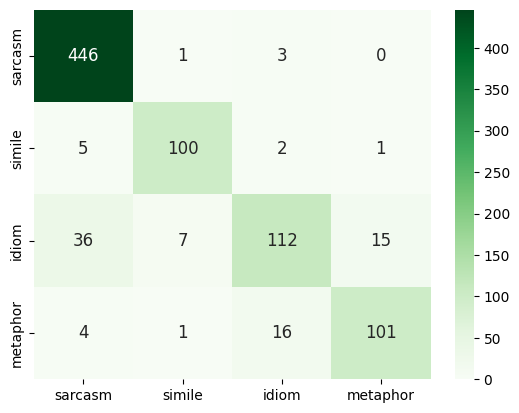

In [9]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
train_model(rf, "rf", X_train, y_train, X_test, y_test)

## 3.2 Logistic regression

              precision    recall  f1-score   support

     sarcasm       0.92      1.00      0.96       450
       idiom       0.81      0.76      0.79       170
      simile       0.89      0.96      0.92       108
    metaphor       0.92      0.66      0.77       122

    accuracy                           0.90       850
   macro avg       0.88      0.84      0.86       850
weighted avg       0.90      0.90      0.89       850



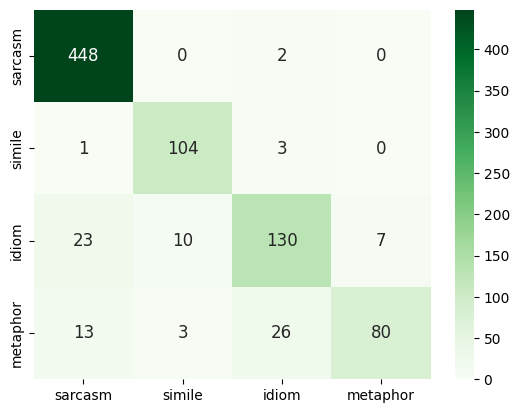

In [10]:
lr = LogisticRegression(solver='sag', multi_class="multinomial", random_state=RANDOM_STATE)
train_model(lr, "lr", X_train, y_train, X_test, y_test)